<a href="https://colab.research.google.com/github/dev-69/MajorProject/blob/main/ModelExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df = pd.read_pickle("/content/drive/MyDrive/Major Project Learnings/Prepared_Data.pkl")
df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,index,CATEGORY,TEXT,OUTPUT_LABEL
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN,48470.0,Discharge summary,Admission Date: [**2101-10-20**] Discharg...,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN,4782.0,Discharge summary,Admission Date: [**2191-3-16**] Discharge...,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN,24476.0,Discharge summary,Admission Date: [**2175-5-30**] Dischar...,0
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN,57341.0,Discharge summary,"Name: [**Known lastname 10050**], [**Known fi...",0
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN,34829.0,Discharge summary,Admission Date: [**2178-4-16**] ...,0


In [3]:
df.TEXT = df.TEXT.fillna(' ')
df.TEXT = df.TEXT.str.replace('\n',' ')
df.TEXT = df.TEXT.str.replace('\r',' ')
df.TEXT = df.TEXT.str.lower()
df.TEXT = df.TEXT.str.replace(r'[^a-zA-Z\s]', '', regex=True)
df.TEXT = df.TEXT.str.replace(r'\s+', ' ', regex=True)
df.TEXT = df.TEXT.str.strip()

In [4]:
df_filtered = df[['SUBJECT_ID', 'HADM_ID', 'TEXT', 'OUTPUT_LABEL']]
X = df_filtered['TEXT']
y = df_filtered['OUTPUT_LABEL']

df_filtered['OUTPUT_LABEL'].value_counts()


,count
OUTPUT_LABEL,
0,48109
1,3004


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_filtered['TEXT'], df_filtered['OUTPUT_LABEL'], test_size=0.2, random_state=42)

In [6]:
import nltk

nltk.download('punkt_tab')
nltk.download('punkt')


from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')
import string
print(string.punctuation)
def tokenizer_better(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=1000, tokenizer=tokenizer_better, stop_words=my_stop_words)
X_train_vect = vect.fit_transform(X)
X_test_vect = vect.transform(X_test)

print("1. Using TF-IDF Vectorizer")

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1. Using TF-IDF Vectorizer


In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN

In [14]:
print("\n🔁 RandomUnderSampler + ADASYN")
rus = RandomUnderSampler()
X_under, y_under = rus.fit_resample(X_train_vect, y)
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X_under, y_under)


🔁 RandomUnderSampler + ADASYN


In [15]:
clf = GradientBoostingClassifier(n_estimators=300)

In [16]:
clf.fit(X_adasyn, y_adasyn)


GradientBoostingClassifier(n_estimators=300)

In [17]:
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

****Results****
AUC: 78.1733%
Classification report: 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.66      0.90      0.79      0.77      0.58      9635
          1       0.14      0.90      0.66      0.24      0.77      0.61       588

avg / total       0.94      0.67      0.89      0.76      0.77      0.58     10223



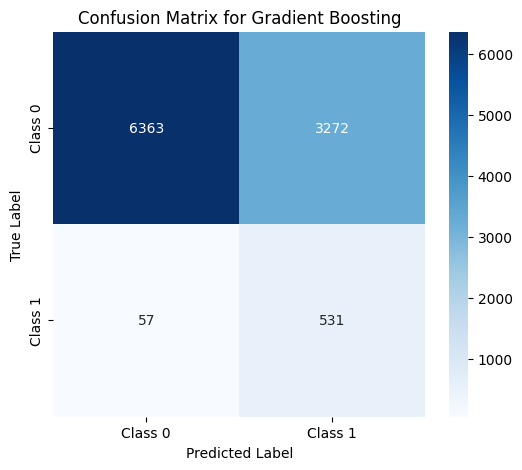

In [18]:
print('****Results****')
train_predictions = clf.predict(X_test_vect)

        # AUC Score
acc = roc_auc_score(y_test, train_predictions)
print("AUC: {:.4%}".format(acc))

        # Classification Report
print("Classification report: \n", classification_report_imbalanced(y_test, train_predictions))

        # Confusion Matrix
cm = confusion_matrix(y_test, train_predictions)

        # Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix for Gradient Boosting')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()